In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
N_Ensemble = 5

par_dir = "/global/cfs/cdirs/m3246/twamorka/H1Unfold_Vinny/H1Unfold/plots/" #dir for Tanvi's parallel ensembles

#scratch_version = 'H1_Sept_FromScratch_closure'
scratch_version = 'H1_Sept_FromScratch_BetterRandom_closure'
pretrain_version = 'H1_Sept_closure_pretrained'

scratch_label = "No Pretrain"
pretrain_label = "With Pretrain"

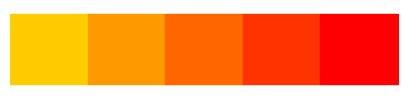

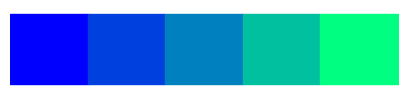

In [3]:
par_colors = plt.get_cmap('autumn')(np.linspace(0.8, 0, N_Ensemble))
step_colors = plt.get_cmap('winter')(np.linspace(0, 1, N_Ensemble))

plt.figure(figsize=(5, 1))
[plt.fill_between([i, i+1], 0, 1, color=color) for i, color in enumerate(par_colors)]
plt.xlim(0, N_Ensemble)
plt.axis('off')
plt.show()
plt.figure(figsize=(5, 1))
[plt.fill_between([i, i+1], 0, 1, color=color) for i, color in enumerate(step_colors)]
plt.xlim(0, N_Ensemble)
plt.axis('off')
plt.show()

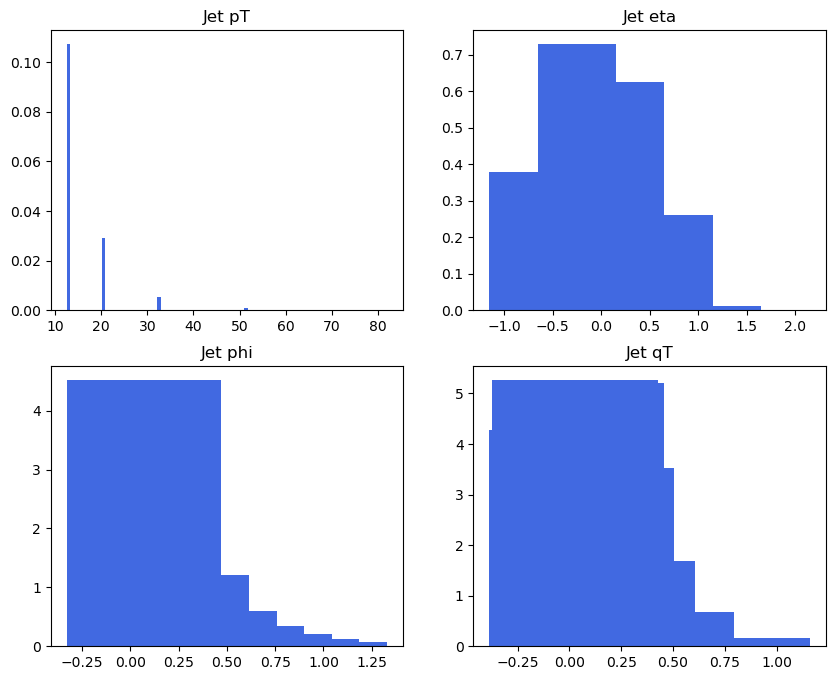

In [4]:
jet_features = ['pT','eta','phi','qT']
fig, axs = plt.subplots(2,2,figsize=(10,8))
axs = axs.ravel()
axs[0].set_title(jet_features[0])


for j,jet_feature in enumerate(jet_features):
    axs[j].set_title(f'Jet {jet_features[j]}')
    jet_files = glob.glob(f'Rapgap_unfolded*_{scratch_version}_jet_{jet_features[j]}*plot_vals.npy')
    for jet_file in jet_files:
        jet_data = np.load(jet_file)
        axs[j].bar(jet_data[0],jet_data[1],color='royalblue')

#
# Plot Code
#

In [5]:
def plot_distributions(version1, label1, version2, label2, feature_names, feature_labels, dir1='', dir2=''):

    #Plot Distributions
    fig = plt.figure(figsize=(12, 24))
    outer_gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.3, wspace=0.3) #4rows, 2cols
    alpha = 0.8
    
    for j,feature in enumerate(feature_names):
        
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[j], height_ratios=[2, 1], hspace=0.1)
    
        rapgap = np.load(f'{dir1}Rapgap_{scratch_version}_{feature}_ens0_plot_vals.npy')
        djangoh = np.load(f'{dir2}Djangoh_{scratch_version}_{feature}_ens0_plot_vals.npy')
    
        # Define the subplots; top plot takes up 3 parts, bottom plot takes up 1 part
        ax1 = fig.add_subplot(gs[:1, 0])  # This is the top subplot
        ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)   # This is the bottom subplot
        
        r_scatter = ax1.scatter(rapgap[0], rapgap[1], marker='o', linestyle='-',label='Rapgap',alpha=alpha,s=10,color='g')
        d_scatter = ax1.fill_between(djangoh[0], djangoh[1], step='mid', color='gray', alpha=0.3,label='Djangoh')
        
        first_legend = ax1.legend(handles=[r_scatter, d_scatter],loc='lower left',fontsize=7)
        ax1.add_artist(first_legend)
    
        
        ax1.set_title(f'{feature_labels[j]}',fontsize=20)
        ax1.set_ylabel('Normalized Counts',fontsize=13)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.grid(True)
        plt.setp(ax1.get_xticklabels(), visible=False)
    
        ax2.set_ylabel(r'Ratio',fontsize=13)
        ax2.set_xlabel(f'{feature_labels[j]}',fontsize=13)
        ax2.set_ylim(0.5,1.5)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        
        ax2.grid(True)
    
        handles = []
    
        for n in range(N_Ensemble):
            step_data = np.load(f'{dir1}Rapgap_unfolded{n}_{version1}_{feature}_ens{n}_plot_vals.npy')        
            step_shift = max(step_data[0])/len(step_data)/10/(n+1)
            handles.append(ax1.scatter(step_data[0]-step_shift, step_data[1], marker='^', color=step_colors[n], alpha=alpha-0.1, linestyle='-',label=f'{label1} {n}'))
            ax2.scatter(step_data[0]-step_shift, step_data[2], marker='^', color=step_colors[n], alpha=alpha, linestyle='-',label=f'Step Ens. {n}')
    
        for n in range(N_Ensemble):
            par_data = np.load(f'{dir2}Rapgap_unfolded{n}_{version2}_{feature}_ens{n}_plot_vals.npy')
            par_shift = max(par_data[0])/len(par_data[0])/10/(n+1)
            handles.append(ax1.scatter(par_data[0]+par_shift, par_data[1], marker='+',s=80, color=par_colors[n], alpha=alpha, linestyle='-',label=f'{label2} {n}'))
            ax2.scatter(par_data[0]+par_shift, par_data[2], marker='+', s=80, color = par_colors[n], alpha=alpha, linestyle='-',label=f'Parallel Ens. {n}')
    
    
        ax1.legend(handles=handles,ncol=2,fontsize=9)



In [6]:
def get_stdv_from_files(files, truth=None):

    data = [np.load(file) for file in files]
    
    # Initialize a dictionary to hold lists of y-values for each x-value index
    y_values_per_x_index = {}
    ratio_values_per_x_index = {}
    x_values = np.load(files[0])[0]  # Load the x-values from the first file



    for single_file_data in data:
        for i, y in enumerate(single_file_data[1]):  # single_file_data[1] are the y-values
            if i not in y_values_per_x_index:
                y_values_per_x_index[i] = []
            y_values_per_x_index[i].append(y)        
    
        for i, r in enumerate(single_file_data[2]):  # single_file_data[1] are the y-values
            if i not in ratio_values_per_x_index:
                ratio_values_per_x_index[i] = []
            ratio_values_per_x_index[i].append(r)
            
    if truth is None: #Standard Deviation, using Means
        std_devs = [np.std(y_values) for y_values in y_values_per_x_index.values()]
        ratio_std_devs = [np.std(y_values) for y_values in ratio_values_per_x_index.values()]

    else: #MSE, from truth. Usually Djanhog in the closure studies
        std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values]) for i, y_values in y_values_per_x_index.items()]
        ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]
        
        #ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]

    return x_values, std_devs, ratio_std_devs

In [7]:
def plot_stdvs(version1, label1, version2, label2, feature_names, feature_labels, dir1='', dir2='', use_truth=False):

    #Plot Standard Deviations
    fig = plt.figure(figsize=(12, 24))
    outer_gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.3, wspace=0.3) #4rows, 2cols
    
    for j,feature in enumerate(feature_names):
        
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[j], height_ratios=[2, 1], hspace=0.1)

        djangoh = None
        sup_str = r'$\sigma = \langle(\mathrm{value} - \mu^\mathrm{ensembles})^2\rangle$'
        metric = r'$\sigma$'
        if use_truth:    
            djangoh = np.load(f'{dir1}Djangoh{feature}_ens0_plot_vals.npy')
            sup_str = r'MSE = $\langle(\mathrm{value} - \mathrm{truth})^2\rangle$'
            metric = 'MSE'
        files1 = glob.glob(f'{dir1}Rapgap_unfolded[0-4]_{version1}_{feature}_ens[0-4]_plot_vals.npy')
        files2 = glob.glob(f'{dir2}Rapgap_unfolded[0-4]_{version2}_{feature}_ens[0-4]_plot_vals.npy')    
    
        x_values, std_devs, ratio_std_devs = get_stdv_from_files(files1,djangoh)
        parr_x, parr_std, parr_ratio = get_stdv_from_files(files2,djangoh)
        
        # Define the subplots; top plot takes up 3 parts, bottom plot takes up 1 part
        ax1 = fig.add_subplot(gs[:1, 0])  # This is the top subplot
        ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)   # This is the bottom subplot
        
        ax1.plot(x_values, std_devs, marker='o', linestyle='-',label=label1)
        ax1.plot(parr_x, parr_std, marker='o', linestyle='-',label=label2)
        ax1.set_title(f'{metric}({feature_labels[j]})',fontsize=20)
        ax1.set_ylabel(f'{metric}',fontsize=13)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.legend()
        ax1.grid(True)
        plt.setp(ax1.get_xticklabels(), visible=False)
        
        ax2.plot(x_values, ratio_std_devs, marker='o', linestyle='-',label=label1)
        ax2.plot(parr_x, parr_ratio, marker='o', linestyle='-',label=label2)
        ax2.set_ylabel(f'{metric} of Ratio',fontsize=13)
        ax2.set_xlabel(f'{feature_labels[j]}',fontsize=13)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        
        ax2.grid(True)

        plt.suptitle(sup_str, va='bottom', y=0.9, fontsize=24)


#
# Jets
#

In [8]:
jet_features = ['jet_pT', 'jet_eta', 'jet_phi', 'jet_qT']
jet_labels = [r'$p_\mathrm{T}^\mathrm{jet}$',r'$\eta^\mathrm{jet}$',
                  r'$\Delta\phi^\mathrm{jet}$',r'$q_\mathrm{T}^\mathrm{jet}$']

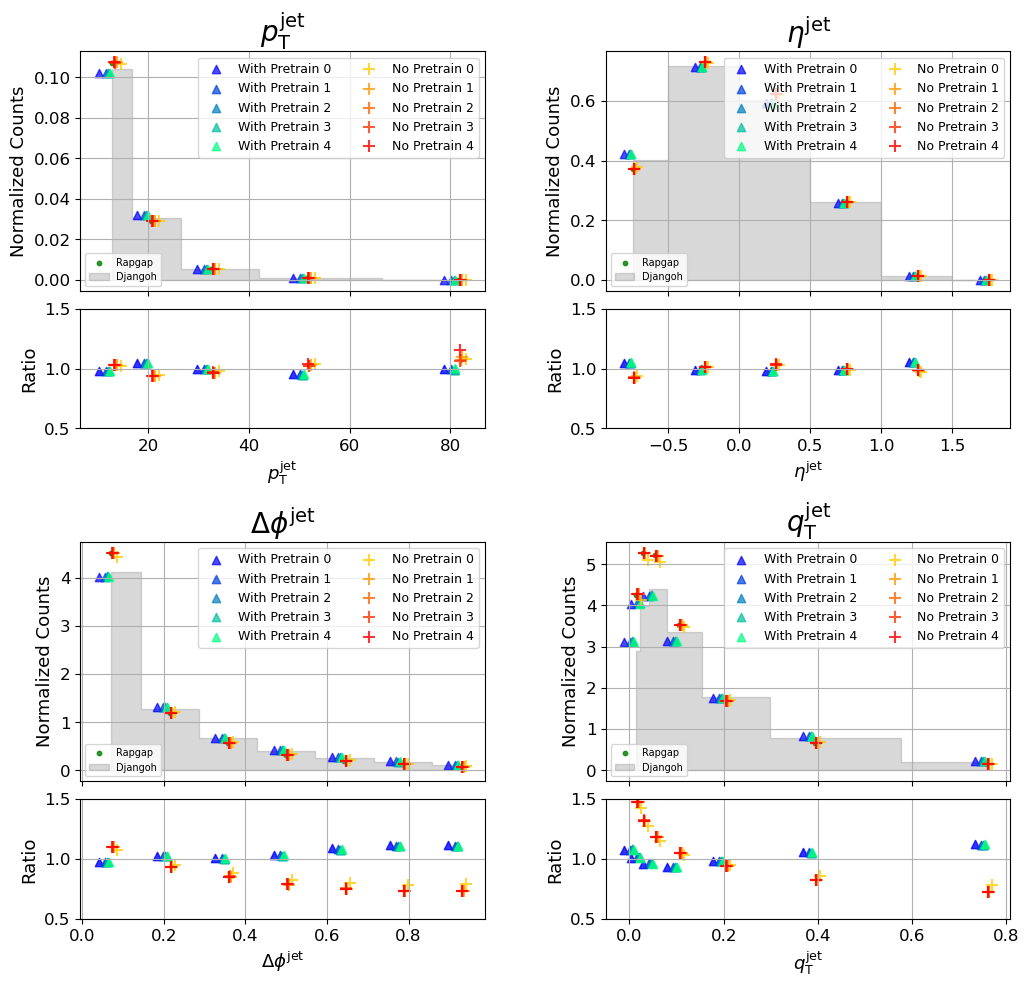

In [9]:
plot_distributions(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', jet_features, jet_labels)

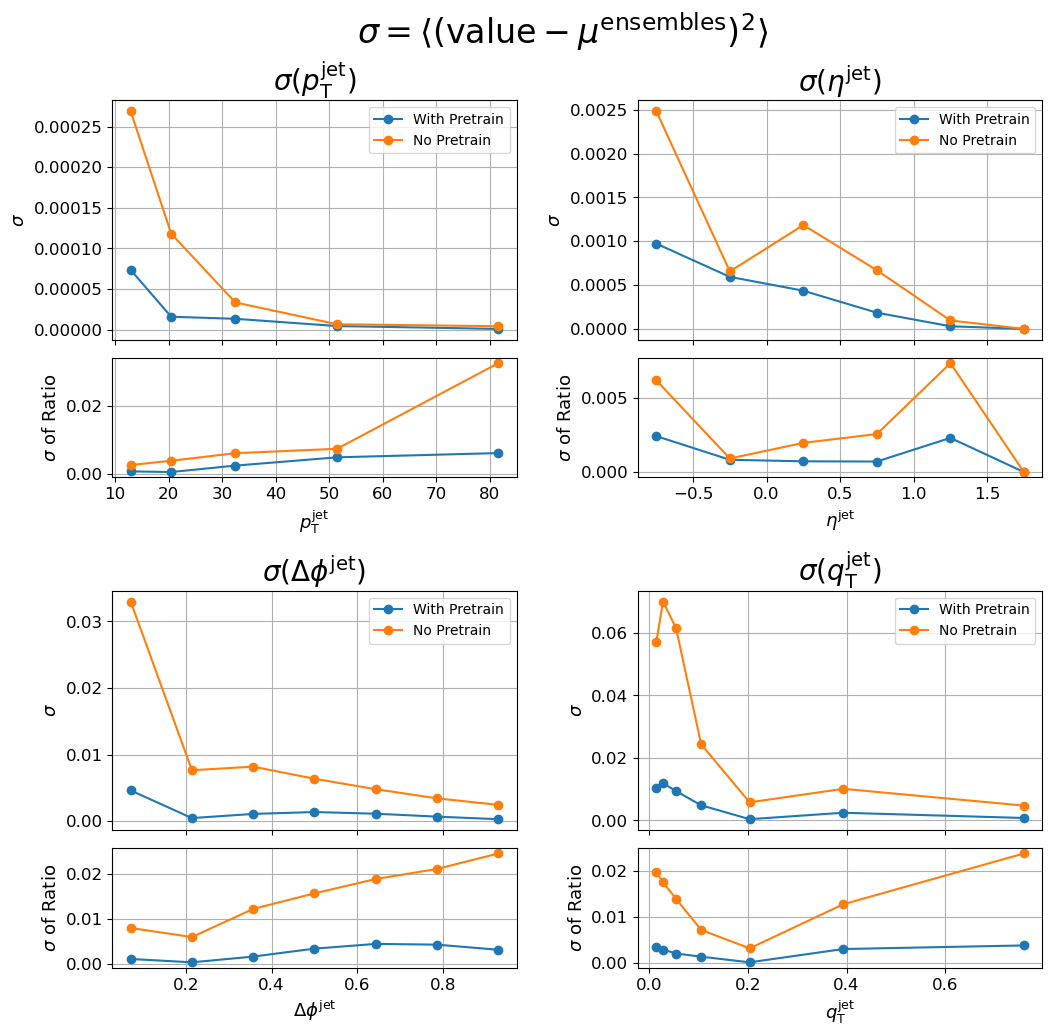

In [10]:
plot_stdvs(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', jet_features, jet_labels)

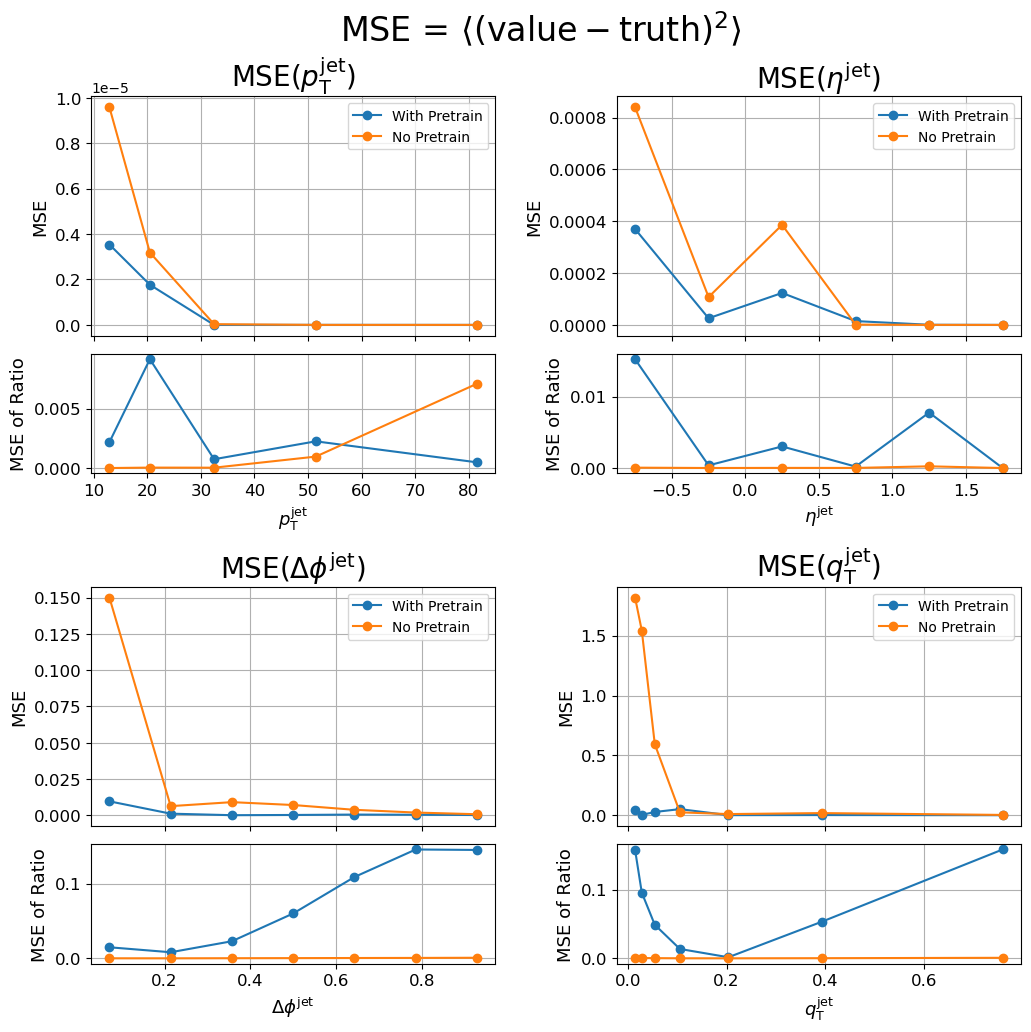

In [11]:
plot_stdvs(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', jet_features, jet_labels,use_truth=True)

#
# Events
#

In [12]:
event_labels = [r'$\log_{10}(Q^2)$',r'$y$',r'$e_{p\mathrm{T}}/Q$',r'$e_\eta$',r'$e_\phi$']
event_features = [f"event{e}" for e in range(len(event_labels))]

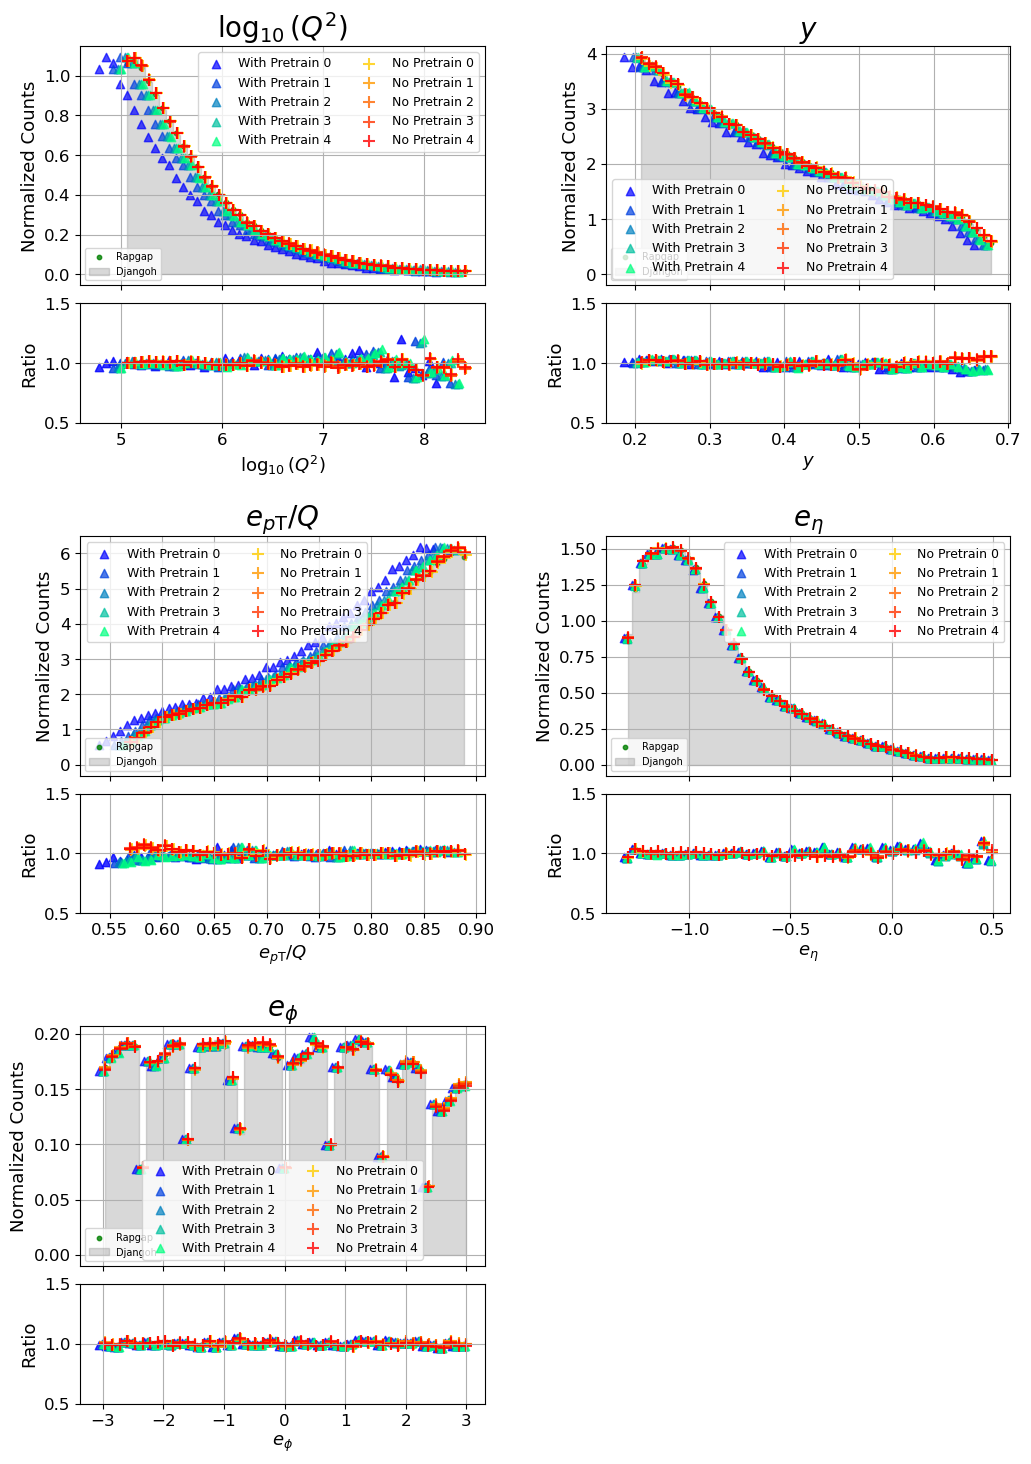

In [13]:
plot_distributions(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', event_features, event_labels)

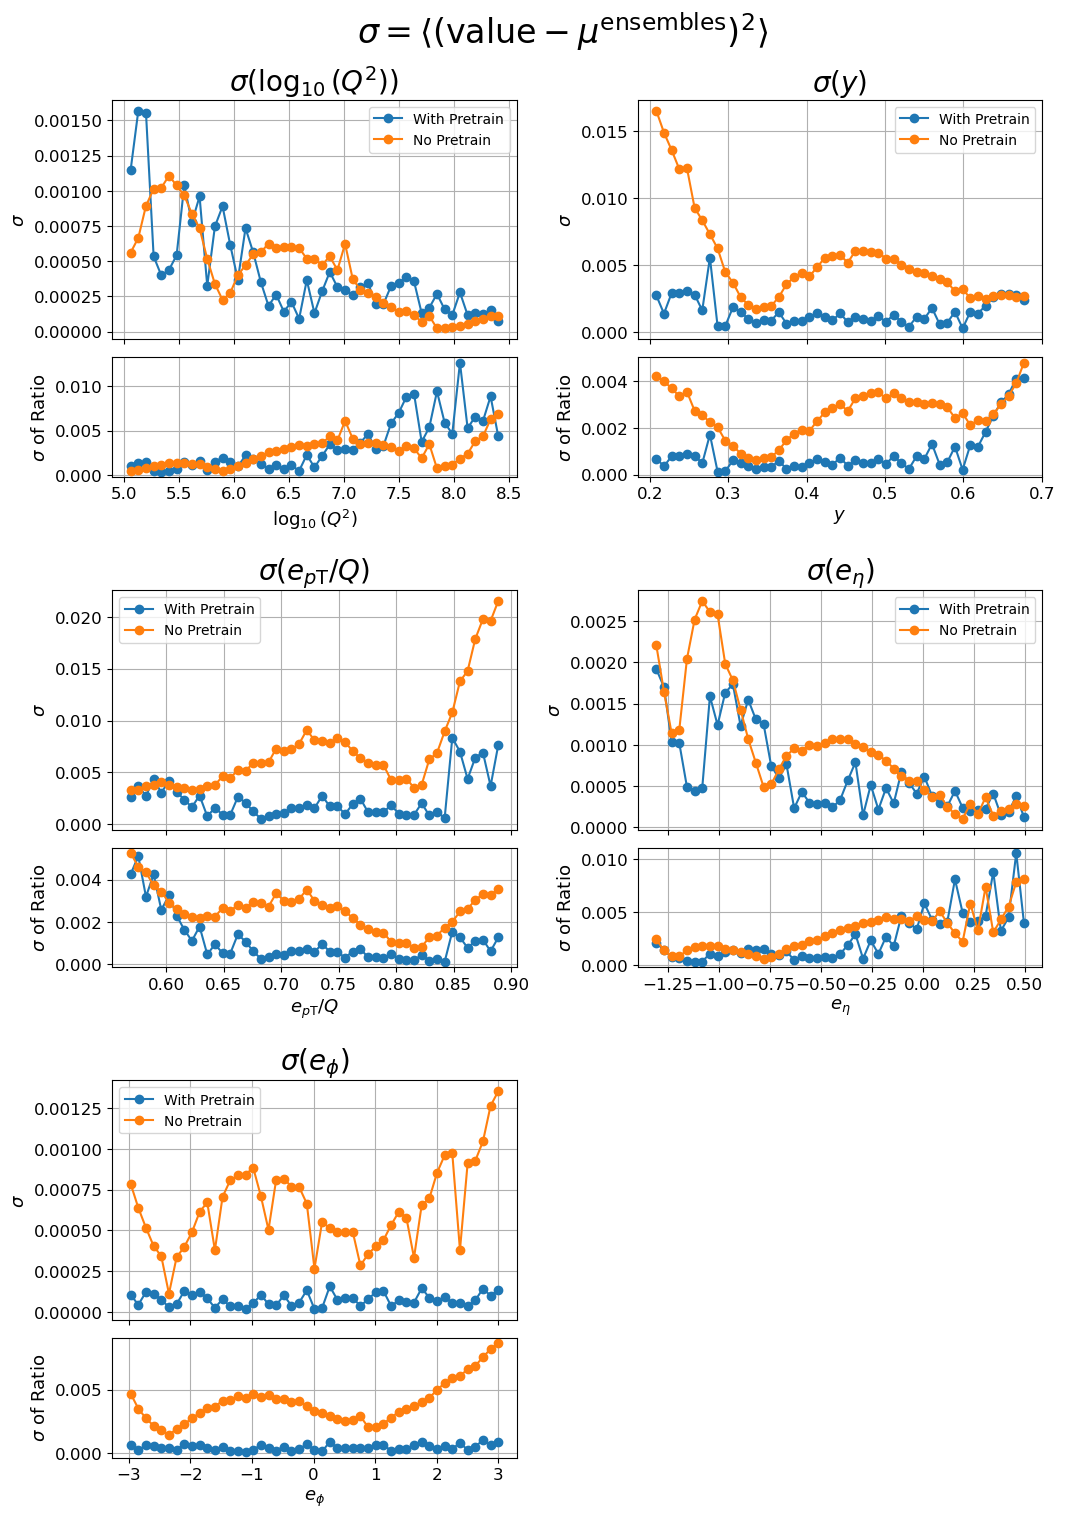

In [14]:
plot_stdvs(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', event_features, event_labels)

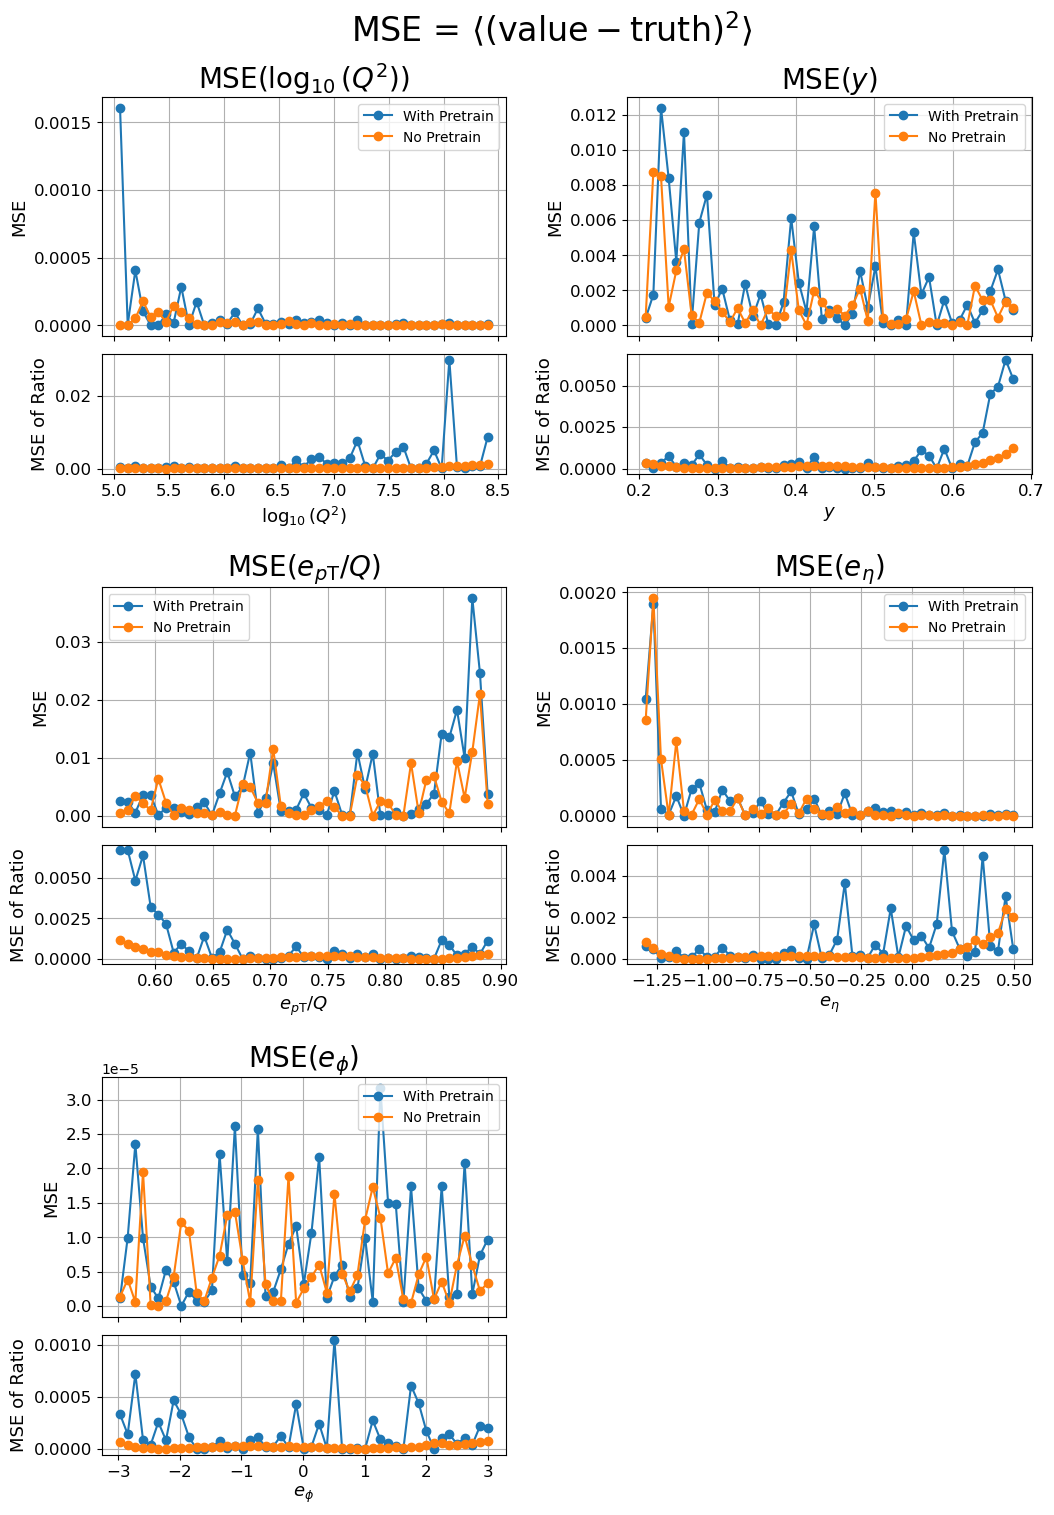

In [18]:
plot_stdvs(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', event_features, event_labels, use_truth=True)

#
# Particles
#

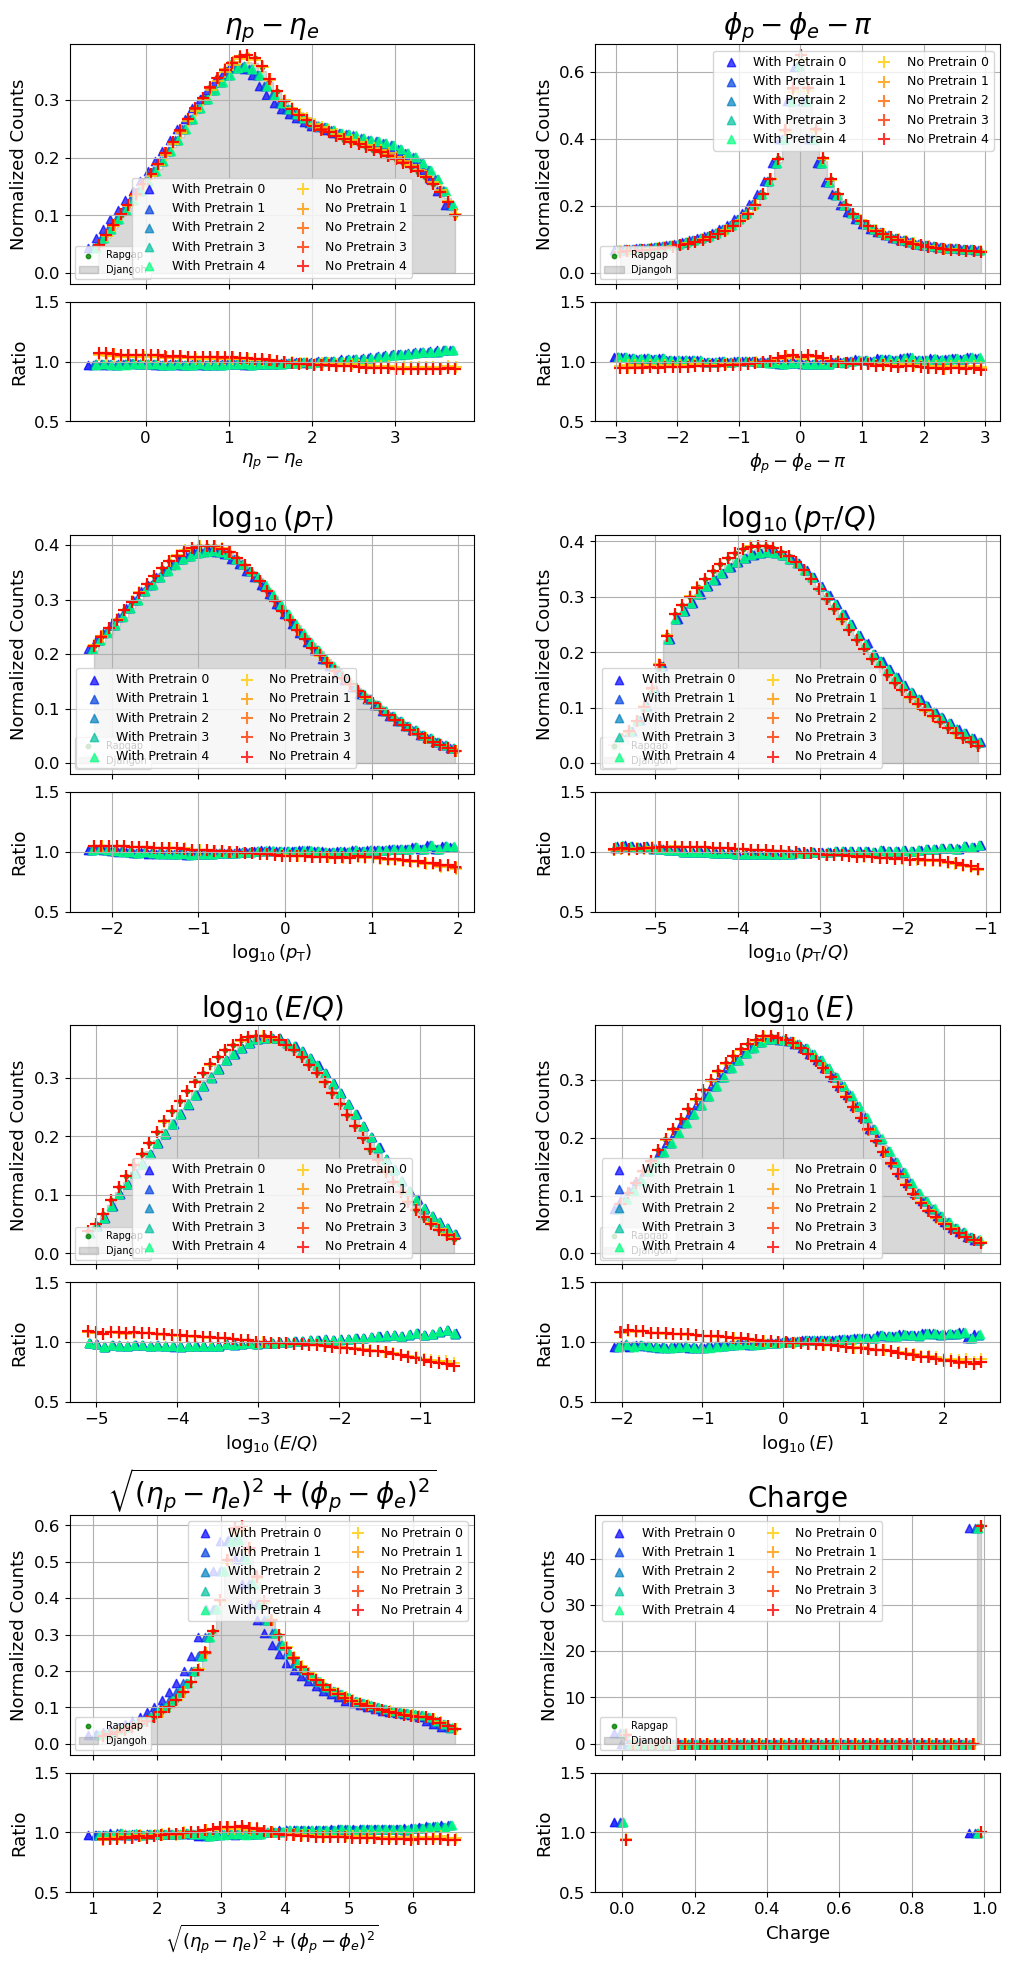

In [15]:
particle_labels = [
    '$\eta_p - \eta_e$',
    '$\phi_p-\phi_e-\pi$',
    '$\log_{10}(p_\mathrm{T})$',
    '$\log_{10}(p_\mathrm{T}/Q)$',
    '$\log_{10}(E/Q)$',
    '$\log_{10}(E)$',
    '$\sqrt{(\eta_p-\eta_e)^2+(\phi_p-\phi_e)^2}$',
    '$\mathrm{Charge}$']

particle_features = [f'particle{p}' for p in range(len(particle_labels))]

plot_distributions(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', particle_features, particle_labels)

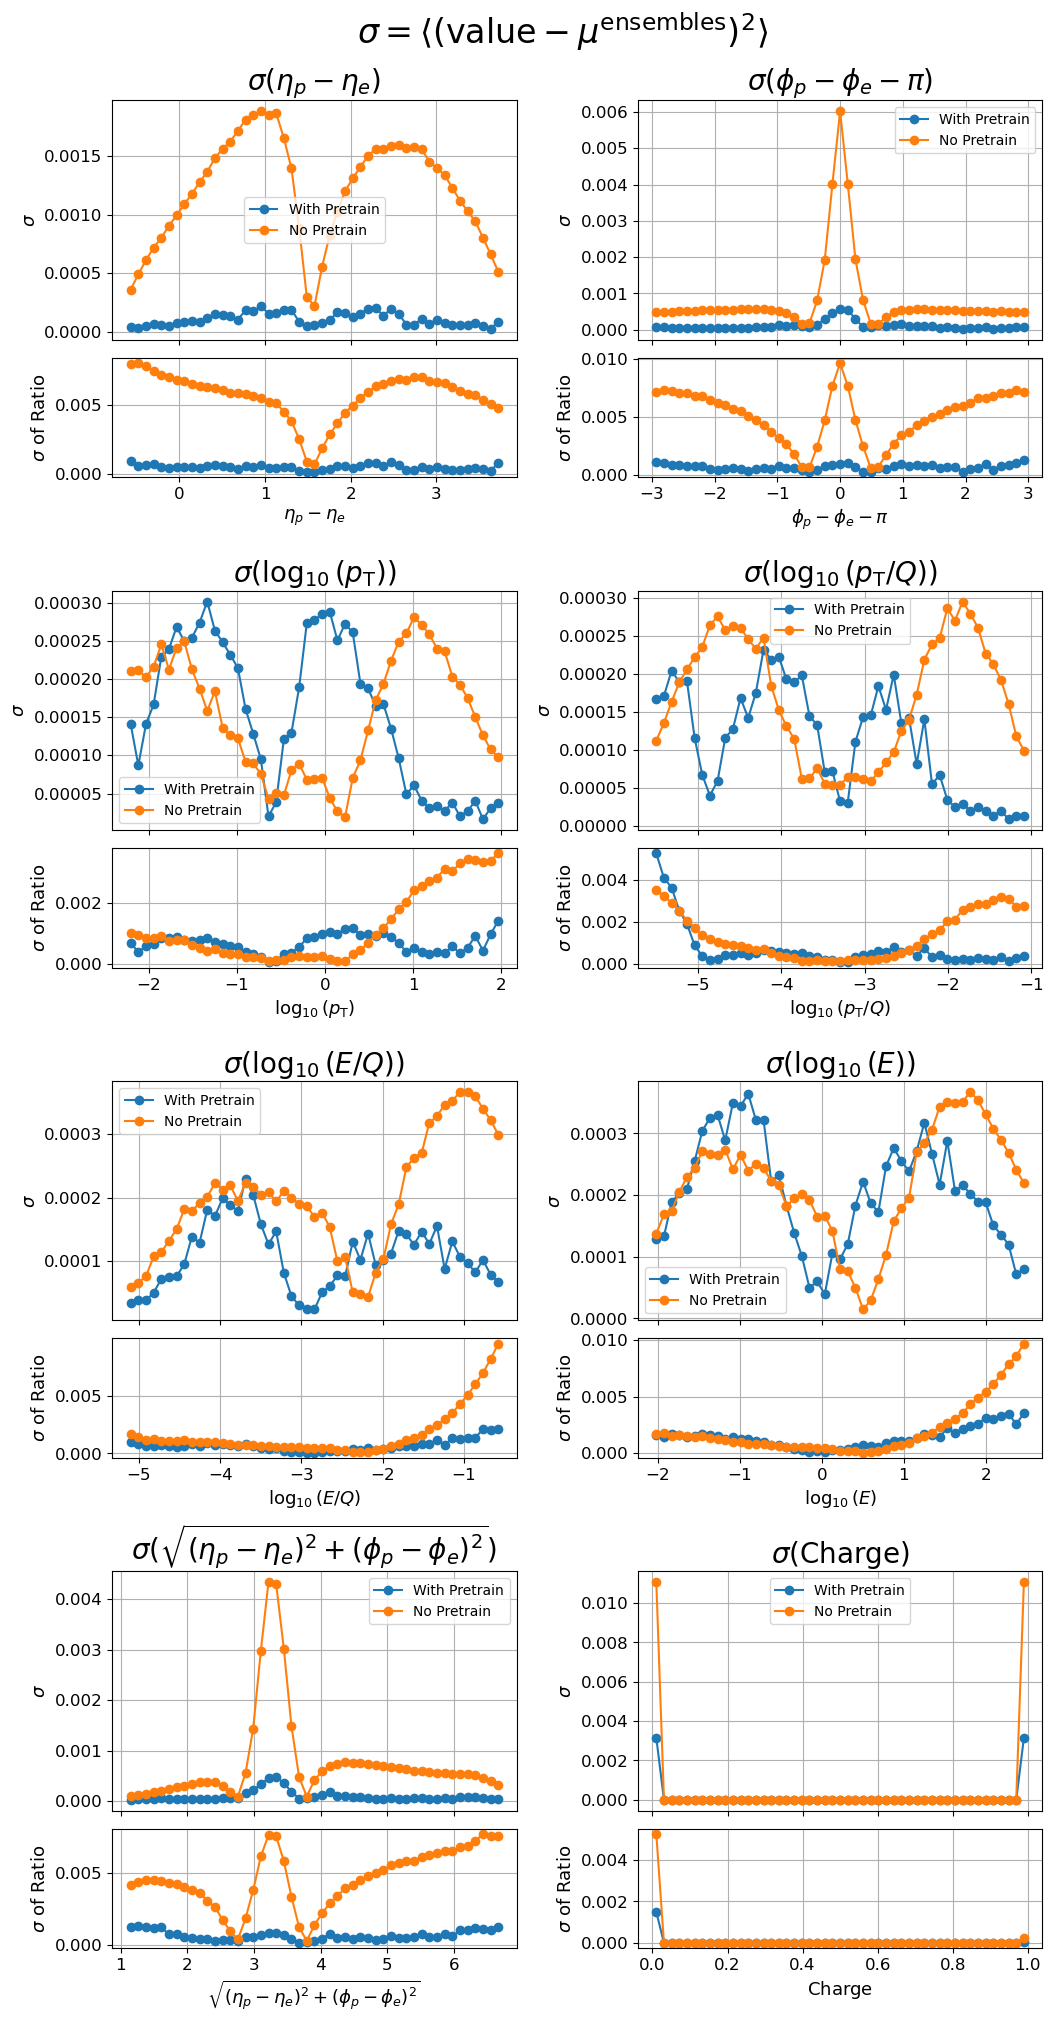

In [16]:
plot_stdvs(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', particle_features, particle_labels)

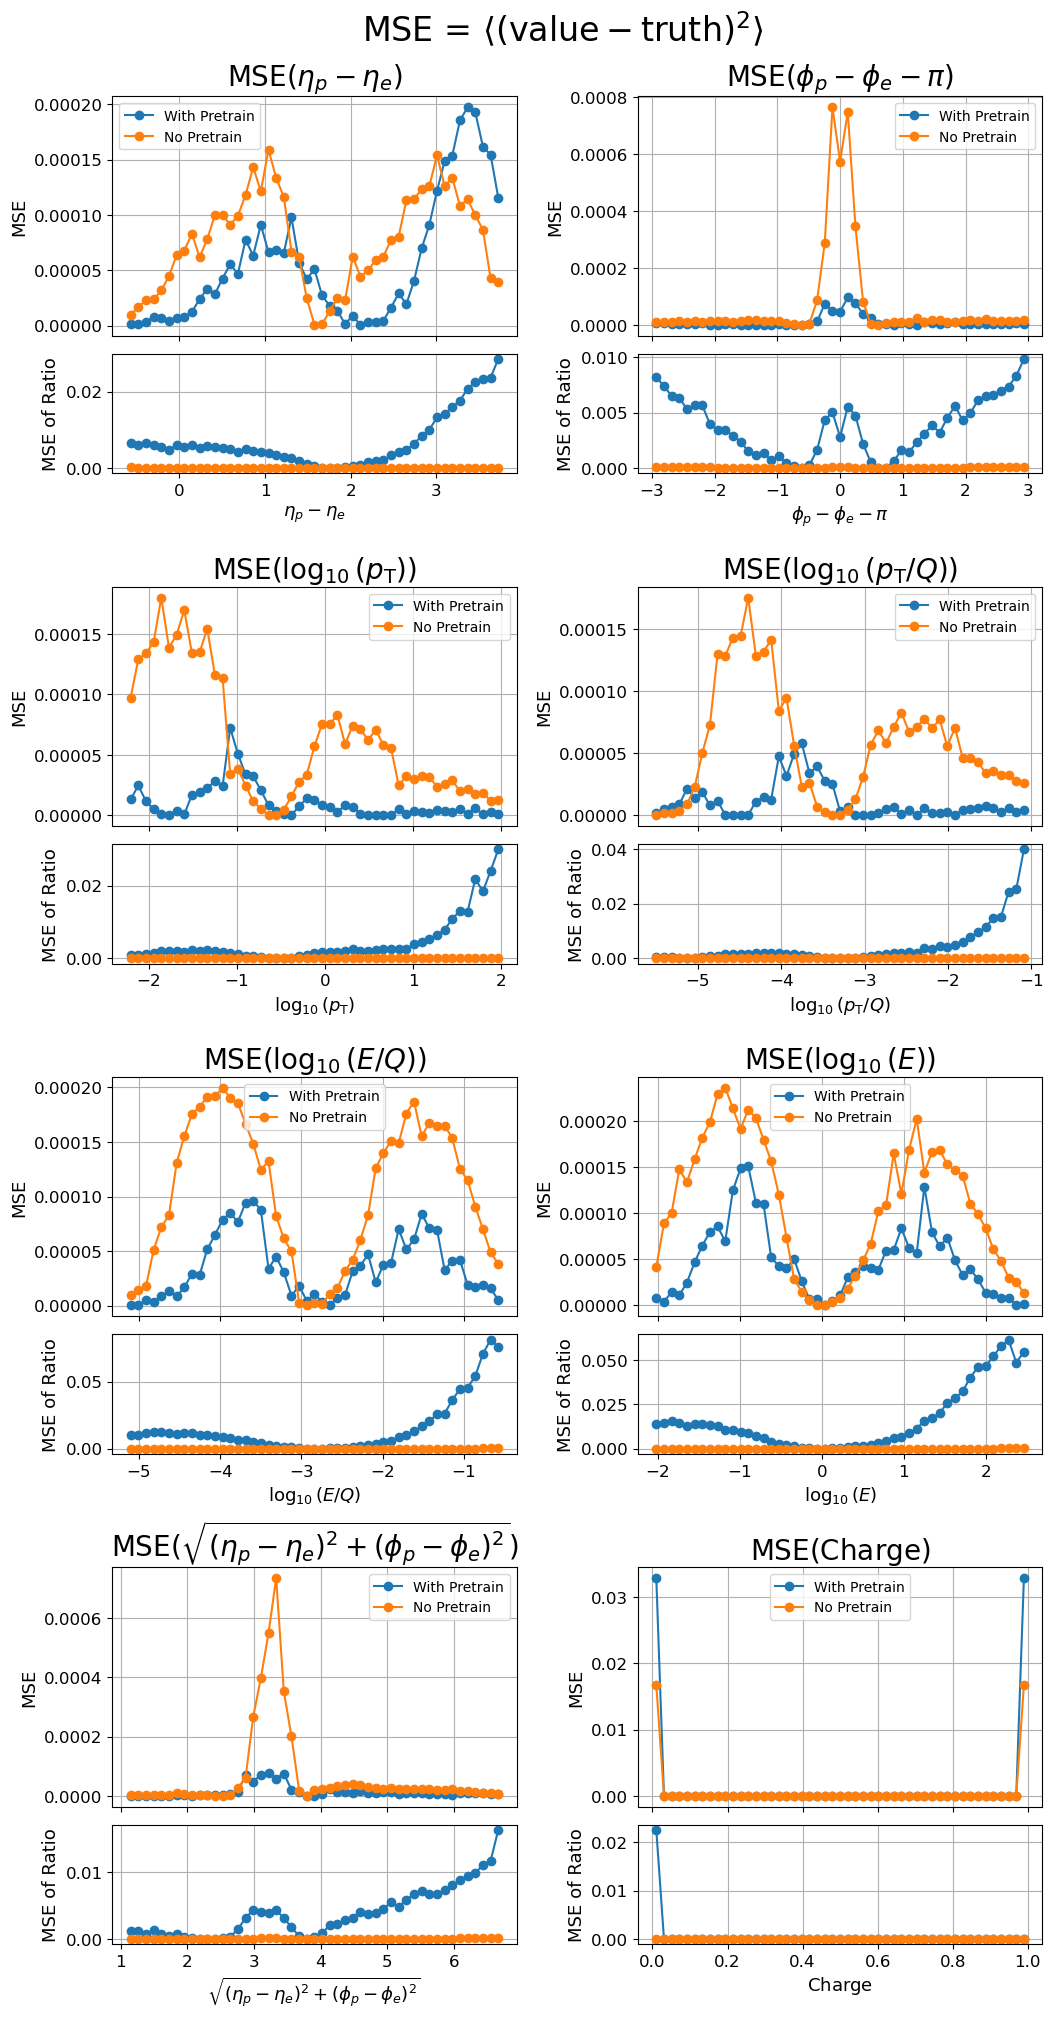

In [17]:
plot_stdvs(pretrain_version, 'With Pretrain', scratch_version,'No Pretrain', particle_features, particle_labels,use_truth=True)